In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

In [76]:
df=pd.read_csv("../data/base_camp.csv",na_values=['-999'])

In [77]:
Humidity = df.drop(['T_HMP', 'PRESS' ,'PRECIP'], axis=1)
Temp = df.drop(['RH', 'PRESS' ,'PRECIP'], axis=1)
Pressure = df.drop(['T_HMP', 'RH' ,'PRECIP'], axis=1)
Precipate = df.drop(['T_HMP', 'PRESS' ,'RH'], axis=1)

In [78]:
Humidity.head()

,TIMESTAMP,RH
0,10/17/19 14:00,99.578
1,10/17/19 15:00,92.273
2,10/17/19 16:00,86.358
3,10/17/19 17:00,88.629
4,10/17/19 18:00,74.045


In [79]:
print(Humidity.shape)
print(Temp.shape)
print(Pressure.shape)
print(Precipate.shape)

(24443, 2)
(24443, 2)
(24443, 2)
(24443, 2)


In [80]:
print("How many NaN are there in the humidity dataset?",Humidity.isna().sum())
print("How many NaN are there in the temperature dataset?",Temp.isna().sum())
print("How many NaN are there in the pressure dataset?",Pressure.isna().sum())

How many NaN are there in the humidity dataset? TIMESTAMP      0
RH           374
dtype: int64
How many NaN are there in the temperature dataset? TIMESTAMP      0
T_HMP        374
dtype: int64
How many NaN are there in the pressure dataset? TIMESTAMP      0
PRESS        374
dtype: int64


In [81]:
Tp = 7000

In [82]:
train_humidity =  np.array(Humidity.RH[:Tp])
#test_humidity =  np.array(Humidity.RH[Tp:])
train_temp =   np.array(Temp.T_HMP[:Tp])
#test_temp =   np.array(Temp.T_HMP[Tp:])
train_pressure =  np.array(Pressure.PRESS[:Tp])
#test_pressure =   np.array(Pressure.PRESS[Tp:])

In [83]:
 np.array(Pressure.PRESS[:Tp])

array([536.71, 537.15, 537.28, ..., 534.14, 534.56, 534.71])

In [84]:
Pressure.head()

,TIMESTAMP,PRESS
0,10/17/19 14:00,536.71
1,10/17/19 15:00,537.15
2,10/17/19 16:00,537.28
3,10/17/19 17:00,537.25
4,10/17/19 18:00,537.22


In [85]:
def plot_train_points(quantity='humidity',Tp=7000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of first {} data points".format(Tp),fontsize=16)
        plt.plot(train_humidity,c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
        plt.plot(train_temp,c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of first {} data points".format(Tp),fontsize=16)
        plt.plot(train_pressure,c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

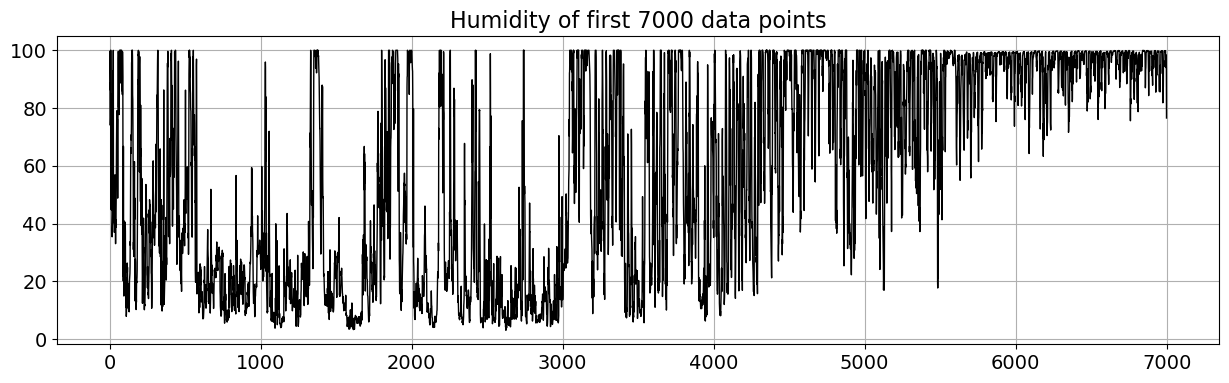

In [86]:
plot_train_points('humidity')

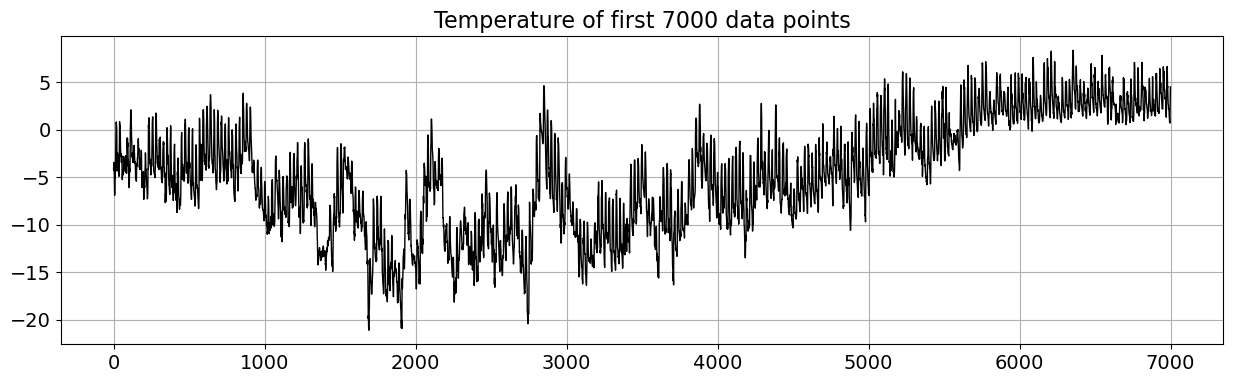

In [87]:
plot_train_points('temperature')

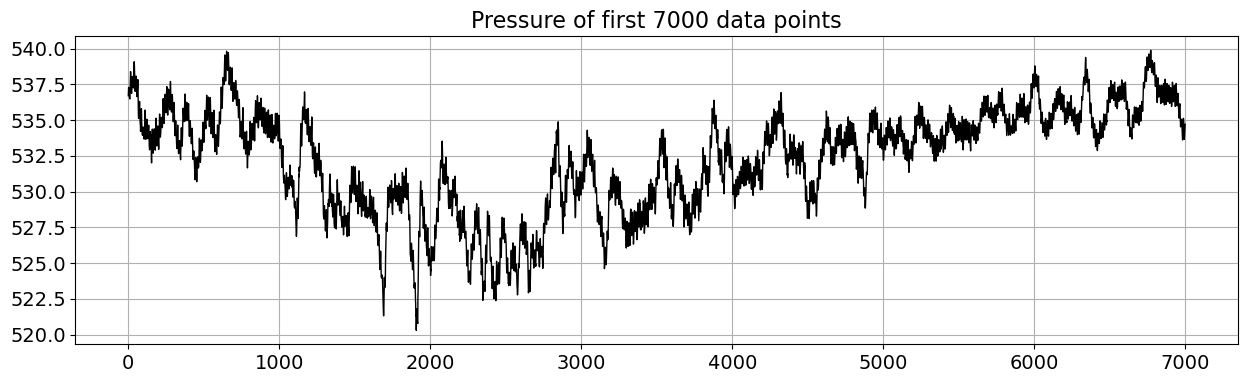

In [88]:
plot_train_points('pressure')

## Data interpolate and fill Nan values

In [89]:
Humidity.interpolate(inplace=True)
Humidity.dropna(inplace=True)

Temp.interpolate(inplace=True)
Temp.dropna(inplace=True)

Pressure.interpolate(inplace=True)
Pressure.dropna(inplace=True)

In [90]:
print(Humidity.shape)
print(Temp.shape)
print(Pressure.shape)

(24443, 2)
(24443, 2)
(24443, 2)


# RNN model for humidity

### Train and test splits on the tp = 7000

In [18]:
train_humidity =  np.array(Humidity.RH[:Tp])
test_humidity =  np.array(Humidity.RH[Tp:])

In [19]:
print("Train data length:", train_humidity.shape)
print("Test data length:", test_humidity.shape)

Train data length: (7000,)
Test data length: (17443,)


In [20]:
train_humidity=train_humidity.reshape(-1,1)
test_humidity=test_humidity.reshape(-1,1)

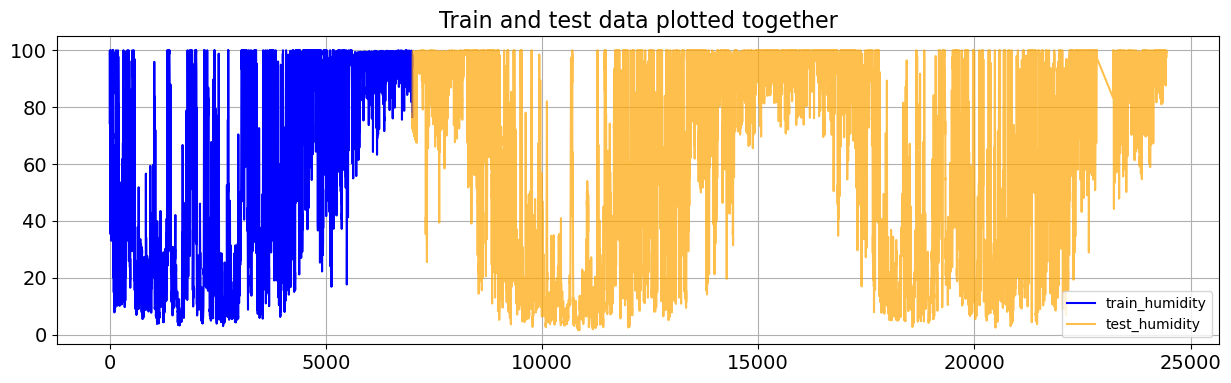

In [21]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together",fontsize=16)
plt.plot(np.arange(Tp),train_humidity,c='blue')
plt.plot(np.arange(Tp,24443),test_humidity,c='orange',alpha=0.7)
plt.legend(['train_humidity','test_humidity'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [22]:
step = 8

In [23]:
# add step elements into train and test
test_humidity = np.append(test_humidity,np.repeat(test_humidity[-1,],step))
train_humidity = np.append(train_humidity,np.repeat(train_humidity[-1,],step))

In [24]:
print("Train data length:", train_humidity.shape)
print("Test data length:", test_humidity.shape)

Train data length: (7008,)
Test data length: (17451,)


In [25]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [26]:
trainX,trainY =convertToMatrix(train_humidity,step)
testX,testY =convertToMatrix(test_humidity,step)

In [27]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [28]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (7000, 1, 8) ,  (7000,)
Test data shape: (17443, 1, 8) ,  (17443,)


## MODEL

In [29]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [30]:
model_humidity = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [31]:
model_humidity.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17536     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,697
Trainable params: 21,697
Non-trainable params: 0
_________________________________________________________________


In [32]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [33]:
batch_size=8
num_epochs = 1000

In [34]:
model_humidity.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


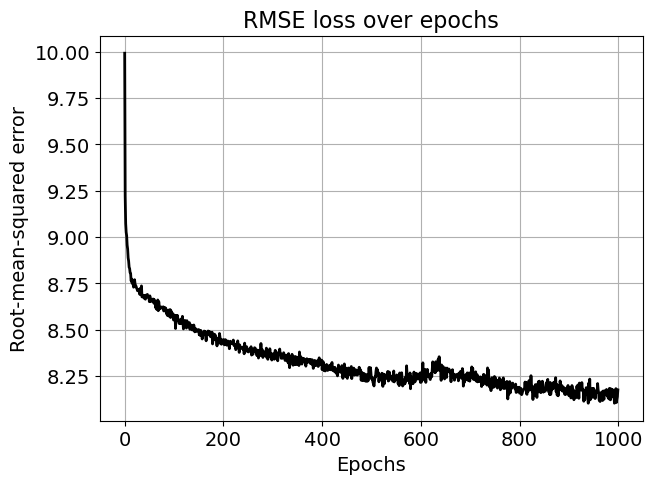

In [35]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

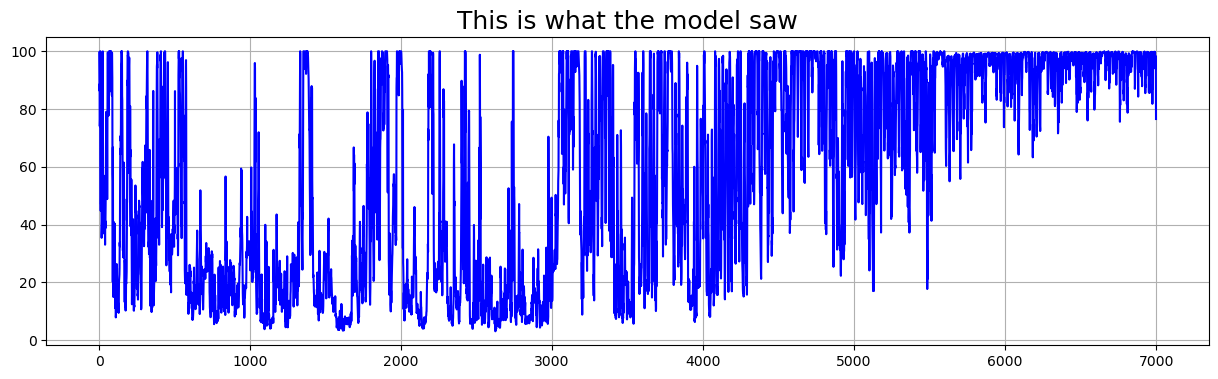

In [36]:
plt.figure(figsize=(15,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [37]:
trainPredict = model_humidity.predict(trainX)
testPredict= model_humidity.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

546/546 [==============================] - 1s 1ms/step


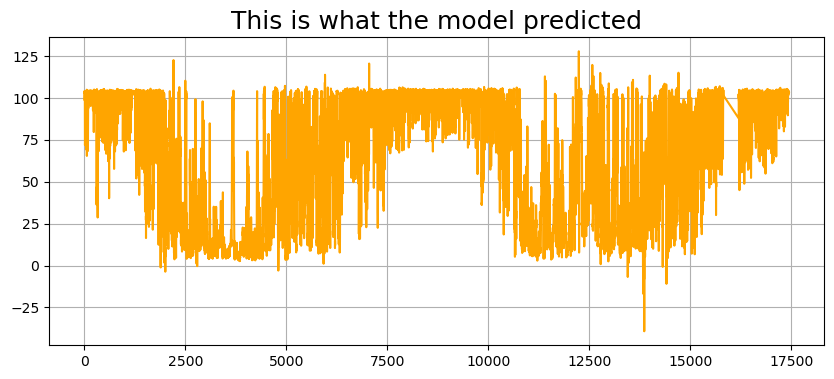

In [38]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

In [91]:
Humidity.index.values

array([    0,     1,     2, ..., 24440, 24441, 24442], dtype=int64)

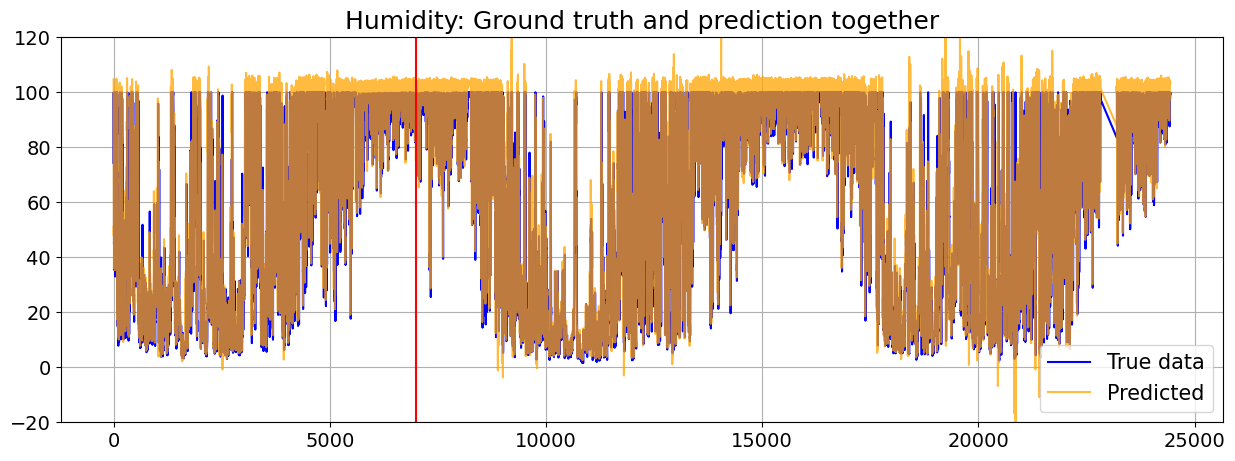

In [94]:
index = Humidity.index.values

plt.figure(figsize=(15,5))
plt.title("Humidity: Ground truth and prediction together",fontsize=18)
plt.plot(index,np.array(Humidity.RH),c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()